# SNN that detects Network bursts in a single channel (Fixed-Precision)
This notebook is a simple example of how to use a Spiking Neural Network (SNN) to detect network bursts in a single channel. 

## Definition of a network burst
A network burst is a sequence of spikes that occur in a short time window. The definition of a network burst is not unique and depends on the context. 

In this notebook, we will **consider a network burst any sequence of spikes that occurs within 10 ms**

### Check WD (change if necessary) and file loading

In [144]:
# Show current directory
import os
curr_dir = os.getcwd()
print(curr_dir)

# Check if the current WD is the file location
if "/src/network_bursts" not in os.getcwd():
    # Set working directory to this file location
    file_location = f"{os.getcwd()}/thesis-lava/src/network_bursts"
    print("File Location: ", file_location)

    # Change the current working Directory
    os.chdir(file_location)

    # New Working Directory
    print("New Working Directory: ", os.getcwd())

/home/monkin/Desktop/feup/thesis/thesis-lava/src/network_bursts


In [145]:
# Add parent directory to path
import sys
sys.path.append('../')

print(sys.path)

['/home/monkin/Desktop/feup/thesis', '/home/monkin/Desktop/feup/thesis/thesis-lava/src', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/monkin/Desktop/feup/thesis/thesis-lava/.venv/lib/python3.10/site-packages', '/home/monkin/Desktop/feup/thesis/lava-dl/src', '/home/monkin/Desktop/feup/thesis/lava-dl', '/home/monkin/Desktop/feup/thesis/thesis-lava/.venv/src/lava/src', '/home/monkin/Desktop/feup/thesis/thesis-lava/.venv/src/lava', '../', '../', '../', '../', '../', '../', '../', '../']


In [146]:
from lava.proc.lif.process import LIF, LogConfig
from lava.proc.dense.process import Dense

LIF?

Init signature: LIF(*args, **kwargs)
Docstring:     
Leaky-Integrate-and-Fire (LIF) neural Process.

LIF dynamics abstracts to:
u[t] = u[t-1] * (1-du) + a_in         # neuron current
v[t] = v[t-1] * (1-dv) + u[t] + bias  # neuron voltage
s_out = v[t] > vth                    # spike if threshold is exceeded
v[t] = 0                              # reset at spike

Parameters
----------
shape : tuple(int)
    Number and topology of LIF neurons.
u : float, list, numpy.ndarray, optional
    Initial value of the neurons' current.
v : float, list, numpy.ndarray, optional
    Initial value of the neurons' voltage (membrane potential).
du : float, optional
    Inverse of decay time-constant for current decay. Currently, only a
    single decay can be set for the entire population of neurons.
dv : float, optional
    Inverse of decay time-constant for voltage decay. Currently, only a
    single decay can be set for the entire population of neurons.
bias_mant : float, list, numpy.ndarray, optiona

## Define the Parameters of the network (Floating-Precision)

In [147]:
# Define the number of neurons in each LIF Layer
n1 = 8   # Let's create a simple program with only 1 LIF layer

# LIF Layer Parameters
v_th = 1
v_init = 0
du = 0.4
dv = 0.05

# Simulation Parameters
init_offset = 1000                  
virtual_time_step_interval = 1  
num_steps = 500      # 3000  # 26500     # TODO: Check the number of steps to run the simulation for

## Define the Weights of the Dense Layer (Floating Precision)

In [148]:
import numpy as np

# Define the matrix of weights
dense_weights = np.eye(n1)

# Scale the weights
weights_scale = 0.3
# dense_weights = np.round(dense_weights * weights_scale).astype(np.int32)
dense_weights = dense_weights * weights_scale

print(dense_weights)

[[0.3 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.3 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.3 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.3 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.3 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.3 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.3 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.3]]


## Convert the necessary LIF Parameters to integers (Float -> Integer)

In [149]:
from utils.float_to_fixed import lif_params_float2fixed, LIFFloat2FixedParams

# Define the LIF parameters
lif_params = LIFFloat2FixedParams(
    u_interval=[0, 1.5],
    v_interval=[0, 1.5],
    weights=dense_weights,
    v_th=v_th,
    bias=0,   # TODO: CHECK THIS
)

# Convert the LIF parameters to fixed point
lif_params_fixed = lif_params_float2fixed(lif_params)
print(lif_params_fixed)

LIFFixedParams(
	v_th=87381, 
	bias_mant=0, bias_exp=0, 
	weights=
[[26214     0     0     0     0     0     0     0]
 [    0 26214     0     0     0     0     0     0]
 [    0     0 26214     0     0     0     0     0]
 [    0     0     0 26214     0     0     0     0]
 [    0     0     0     0 26214     0     0     0]
 [    0     0     0     0     0 26214     0     0]
 [    0     0     0     0     0     0 26214     0]
 [    0     0     0     0     0     0     0 26214]], 
	weight_exp=0)


In [150]:
from utils.float_to_fixed import scaling_dudv

scaled_du = scaling_dudv(du)
scaled_dv = scaling_dudv(dv)

print(f"Scaled du / dv: {scaled_du} / {scaled_dv}")

Scaled du / dv: 1638 / 205


In [151]:
# Should we scale the voltage threshold?
scaled_down_vth = lif_params_fixed.v_th >> 6
print(f"Scaled Down v_th: {scaled_down_vth}")

Scaled Down v_th: 87381


In [152]:
import logging

# Create Processes
lif1 = LIF(shape=(n1,),  # There are 2 neurons
           vth=scaled_down_vth,    # lif_params_fixed.v_th,  # TODO: Verify these initial values
           v=v_init,
           dv=scaled_dv,    # Inverse of decay time-constant for voltage decay
           du=scaled_du,  # Inverse of decay time-constant for current decay
           bias_mant=0,
           bias_exp=0,
           log_config=LogConfig(level=logging.INFO),
           name="lif1")

## Define the Dense Layer (Fixed Precision)

In [153]:
# Instantiante a Dense Layer to connect the SpikeEventGen to the middle layer
dense_input = Dense(
    weights=lif_params_fixed.weights,   # 1-1 connectivity with the Middle Layer (should be a 8x8 matrix right now)
    weight_exp=lif_params_fixed.weight_exp,
    name="DenseInput"
)

# Weights of the Input Dense Layer
dense_input.weights.get()

array([[26214,     0,     0,     0,     0,     0,     0,     0],
       [    0, 26214,     0,     0,     0,     0,     0,     0],
       [    0,     0, 26214,     0,     0,     0,     0,     0],
       [    0,     0,     0, 26214,     0,     0,     0,     0],
       [    0,     0,     0,     0, 26214,     0,     0,     0],
       [    0,     0,     0,     0,     0, 26214,     0,     0],
       [    0,     0,     0,     0,     0,     0, 26214,     0],
       [    0,     0,     0,     0,     0,     0,     0, 26214]],
      dtype=int32)

In [154]:
for proc in [lif1, dense_input]:
    for port in proc.in_ports:
        print(f"Proc: {proc.name:<5} Port Name: {port.name:<5} Size: {port.size}")
    for port in proc.out_ports:
        print(f"Proc: {proc.name:<5} Port Name: {port.name:<5} Size: {port.size}")

Proc: lif1  Port Name: a_in  Size: 8
Proc: lif1  Port Name: s_out Size: 8
Proc: DenseInput Port Name: s_in  Size: 8
Proc: DenseInput Port Name: a_out Size: 8


## Create the Custom Input Layer

### Define function to read the input data from the csv file and generate the corresponding spike events

In [155]:
import pandas as pd

def read_spike_events(file_path: str):
    """Reads the spike events from the input file and returns them as a numpy array
    TODO: Could try to use a structured array instead?

    Args:
        file_path (str): name of the file containing the spike events
    """
    spike_events = []

    try:
        # Read the spike events from the file
        df = pd.read_csv(file_path, header='infer')
        # print(df.head())

        # Detect errors
        if df.empty:
            raise Exception("The input file is empty")

        # Convert the scientific notation values to integers if any exist
        df = df.applymap(lambda x: int(float(x)) if (isinstance(x, str) and 'e' in x) else x)

        # Convert the dataframe to a numpy array. Each row is a spike event. The first column is the time and the second column is the channel idx
        spike_events = df.to_numpy()

        return spike_events
    except Exception as e:
        print("Unable to read the input file: ", file_path, " error:", e)

    return spike_events

In [156]:
# Call the function to read the spike events
file_path = "data/custom_activations_burst_1.csv"   # "../lab_data/lab_data_1-8channels.csv"
spike_events = read_spike_events(file_path)
print("Spike events: ", spike_events.shape, "\n", spike_events[:10])

Spike events:  (8, 2) 
 [[1005    1]
 [1020    1]
 [1021    1]
 [1033    1]
 [1045    1]
 [1046    1]
 [1090    1]
 [1105    1]]


### Define the SpikeEvent Generator Interface

In [157]:
from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.variable import Var
from lava.magma.core.process.ports.ports import OutPort

class SpikeEventGen(AbstractProcess):
    """Input Process that generates spike events based on the input file

    Args:
        shape (tuple): Shape of the output port
        file_name (str): Name of the file containing the spike events
    """
    def __init__(self, shape: tuple, spike_events: np.ndarray, name: str) -> None:
        super().__init__(name=name)
        self.s_out = OutPort(shape=shape)
        self.spike_events = Var(shape=spike_events.shape, init=spike_events)

### Map the input channels to the corresponding indexes in the input layer
Since the input channels in the input file may be of any number, we need to map the input channels to the corresponding indexes in the input layer. This is done by the `channel_map` dictionary.

In [158]:
# Map the channels of the input file to the respective index in the output list of SpikeEventGen
channel_map = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7}

### Implement the `SpikeEventGenerator` Model

In [159]:
from lava.magma.core.model.py.model import PyLoihiProcessModel  # Processes running on CPU inherit from this class
from lava.magma.core.resources import CPU
from lava.magma.core.decorator import implements, requires
from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol
from lava.magma.core.model.py.type import LavaPyType
from lava.magma.core.model.py.ports import PyOutPort

@implements(proc=SpikeEventGen, protocol=LoihiProtocol)
@requires(CPU)
class PySpikeEventGenModel(PyLoihiProcessModel):
    """Spike Event Generator Process implementation running on CPU (Python)
    Args:
    """
    s_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float)   # IT IS POSSIBLE TO SEND FLOATS AFTER ALL
    spike_events: np.ndarray = LavaPyType(np.ndarray, np.ndarray)   # TODO: Check if we should keep it as a numpy array, or transform it to a list

    def __init__(self, proc_params) -> None:
        super().__init__(proc_params=proc_params)
        self.curr_spike_idx = 0     # Index of the next spiking event to send
        self.virtual_time_step_interval = virtual_time_step_interval  # 1000    # Arbitrary time between time steps (in microseconds). This is not a real time interval (1000ms = 1s)
        self.init_offset = init_offset        # 698995               # Arbitrary offset to start the simulation (in microseconds)

    def run_spk(self) -> None:
        spike_data = np.zeros(self.s_out.shape) # Initialize the spike data to 0
        
        currTime = self.init_offset + self.time_step*self.virtual_time_step_interval

        spiking_channels = set()   # List of channels that will spike at the same time
        while (self.curr_spike_idx < len(self.spike_events)) and currTime >= self.spike_events[self.curr_spike_idx][0]:  # Check if there are more than 1 spike events to send
            if self.spike_events[self.curr_spike_idx][0] < self.init_offset:
                self.curr_spike_idx += 1
                continue
            
            curr_channel = self.spike_events[self.curr_spike_idx][1]

            # Check if the next spike belongs to a channel that will already spike at the same time
            if curr_channel in spiking_channels:    # If the channel is already spiking, we stop the spikes for this time step
                break

            # Add the channel to the list of spiking channels
            spiking_channels.add(curr_channel)

            # Send a spike
            out_idx = channel_map[curr_channel]     # Map the channel to the output index
            if out_idx < self.s_out.shape[0]:   # Check if the channel is valid
                spike_data[out_idx] = 1.0   # Send a spike  (value corresponds to the punctual current of the spike event)

            # Move to the next spike event
            self.curr_spike_idx += 1

        self.s_out.send(spike_data)

### Define a Sink to receive the spikes in a Python Process if necessary

In [160]:
from lava.proc.io.sink import RingBuffer as Sink

sink = Sink(shape=(n1, ), buffer=num_steps)

## Connect the Layers

In [161]:
# Create the Input Process
spike_event_gen = SpikeEventGen(shape=(n1,), spike_events=spike_events, name="CustomInput")

# If I connect the SpikeEventGen to the Dense Layer, the a_out value of the custom input will be rounded to 0 or 1 in the Dense Layer (it will not be a float) 
# ---- Connect the SpikeEventGen to the Dense Layer ----
# Connect SpikeEventGen to the Adapter first
spike_event_gen.s_out.connect(dense_input.s_in)

# ---- Connect the Dense_Input to the LIF1 Layer ----
# Connect the Dense to the Adapter first
dense_input.a_out.connect(lif1.a_in)



# Connect the SpikeEventGen layer directly to the LIF1 layer
# spike_event_gen.s_out.connect(lif1.a_in)

### Take a look at the connections in the Input Layer

In [162]:
for proc in [spike_event_gen, dense_input, lif1]:
    for port in proc.in_ports:
        print(f"Proc: {proc.name:<5} Port Name: {port.name:<5} Size: {port.size}")
    for port in proc.out_ports:
        print(f"Proc: {proc.name:<5} Port Name: {port.name:<5} Size: {port.size}")

Proc: CustomInput Port Name: s_out Size: 8
Proc: DenseInput Port Name: s_in  Size: 8
Proc: DenseInput Port Name: a_out Size: 8
Proc: lif1  Port Name: a_in  Size: 8
Proc: lif1  Port Name: s_out Size: 8


## Record Internal Vars over time
To record the evolution of the internal variables over time in neuromorphic hardware, we need a `StateProbe`. For this example, we want to record the membrane potential and voltage of the `LIF` Layer, hence we need 2 `StateProbes`.

In [163]:
from lava.proc.monitor.process import Monitor

monitor_lif1_v = Monitor()
monitor_lif1_u = Monitor()

# Connect the monitors to the variables we want to monitor
monitor_lif1_v.probe(lif1.v, num_steps)
monitor_lif1_u.probe(lif1.u, num_steps)

## Execution
Now that we have defined the network, we can execute it. We will use the `run` function to execute the network.

### Run Configuration and Conditions

In [164]:
from lava.magma.core.run_conditions import RunContinuous, RunSteps
from lava.magma.core.run_configs import Loihi2SimCfg

# run_condition = RunContinuous()   # TODO: Change to this one
run_condition = RunSteps(num_steps=num_steps)
run_cfg = Loihi2SimCfg(select_tag="fixed_pt")

### Execute

In [165]:
lif1.run(condition=run_condition, run_cfg=run_cfg)

## Let's see which `ProcessModels` were executed

In [166]:
print(f"LIF ProcessModel: {lif1.model_class}")
print(f"SpikeEventGen ProcessModel: {spike_event_gen.model_class}")
print(f"Dense ProcessModel: {dense_input.model_class}")

LIF ProcessModel: <class 'lava.proc.lif.models.PyLifModelBitAcc'>
SpikeEventGen ProcessModel: <class '__main__.PySpikeEventGenModel'>
Dense ProcessModel: <class 'lava.proc.dense.models.PyDenseModelBitAcc'>


### Retrieve recorded data

In [167]:
data_lif1_v = monitor_lif1_v.get_data()
data_lif1_u = monitor_lif1_u.get_data()

data_lif1 = data_lif1_v.copy()
data_lif1["lif1"]["u"] = data_lif1_u["lif1"]["u"]   # Merge the dictionaries to contain both voltage and current

In [168]:
data_lif1

{'lif1': {'v': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'u': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]])}}

In [169]:
# Check the shape to verify if it is printing the voltage for every step
len(data_lif1['lif1']['v'])     # Indeed, there are 300 values (same as the number of steps we ran the simulation for)

500

### Check what is the Voltage Threshold of the LIF Model

In [170]:
print(lif1.vth)

Variable: vth
    shape: (1,)
    init: 87381
    shareable: True
    value: [87381.]


### Plot the recorded data

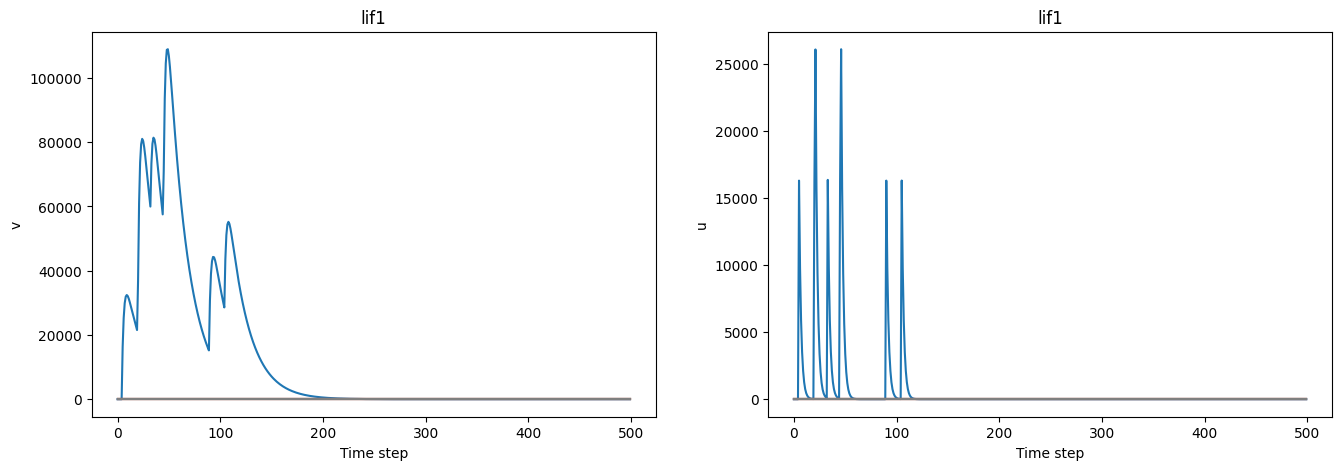

In [171]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

# Create a subplot for each monitored variable
fig = plt.figure(figsize=(16, 5))
ax0 = fig.add_subplot(121)
ax0.set_title('Voltage (V) / time step')
ax1 = fig.add_subplot(122)
ax1.set_title('Current (U) / time step')

# Plot the data
monitor_lif1_v.plot(ax0, lif1.v)
monitor_lif1_u.plot(ax1, lif1.u)

## Find the timesteps where the channel bursts occur

In [172]:
from utils.data_analysis import find_spike_times

# Call the find_spike_times util function that detects the spikes in a voltage array
spike_times_lif1 = find_spike_times(data_lif1['lif1']['v'], data_lif1['lif1']['u'])

# Add the initial offset to the spike times (1st index )
for spike_times in spike_times_lif1:
    spike_times[0] += init_offset
    
print("Spike times: ", spike_times_lif1)

Spike times:  []


## Observations

- Why is the membrane potential of the LIF neurons not reaching the threshold and firing anyway?
  - Is it because it would spike in the next time step? I think that is the case. We can confirm this by using a very low current input and analyze the graph since it won't be as steep.


## View the Voltage and Current dynamics with an interactive plot

Grab the data from the recorded variables

In [173]:
lif1_voltage_vals = data_lif1['lif1']['v']
lif1_current_vals = data_lif1['lif1']['u']

print("v_ch0 shape:", len(lif1_voltage_vals))

# print("voltage head: ", lif1_voltage_vals[:10])

v_ch0 shape: 500


## Bokeh Function to create a figure

In [174]:
# Interactive Plot for the voltage and current
# bokeh docs: https://docs.bokeh.org/en/2.4.1/docs/first_steps/first_steps_1.html
import bokeh.plotting as bplt
from bokeh.io import curdoc
from bokeh.models import BoxAnnotation
from math import ceil

# Apply the theme to the plot
curdoc().theme = "caliber"  # Can be one of "caliber", "dark_minimal", "light_minimal", "night_sky", "contrast"

# colors list
line_colors = ["green", "blue", "red", "orange", "purple", "black", "cyan", "pink", "brown", "mediumaquamarine", "teal", "olive", "darkgreen", 
               "mediumslateblue", "lightsalmon", "gold", "indigo", "aqua", "rosybrown", "chocolate"]  # TODO: Add more colors if needed

""" Only possible in python>= 3.12 
type BoxAnnotationParams = {
    "bottom": float,
    "top": float,
    "left": float,
    "right": float,
    "fill_alpha": float,
    "fill_color": str
} """

"""
create_fig: Create a figure with the given parameters

Args:
    title (str): Title of the plot
    x_axis_label (str): Label of the x-axis
    y_axis_label (str): Label of the y-axis
    x (np.ndarray): Array of x values
    y_arrays (list): List of tuples containing the y values and the legend label
    x_range (tuple): Range of the x-axis    (Can make linked ranges with other plots)
    y_range (tuple): Range of the y-axis
    sizing_mode (str): Sizing mode of the plot
    tools (str): Tools to be added to the plot
    tooltips (str): Tooltips to be added to the plot
    legend_location (str): Location of the legend
    legend_bg_fill_color (str): Background fill color of the legend
    legend_bg_fill_alpha (float): Background fill alpha of the legend
    box_annotation_params (dict): Parameters to create a box annotation
Returns:
    bplt.Figure: The plot
"""
def create_fig(title, x_axis_label, y_axis_label, 
               x, y_arrays, x_range=None, y_range=None,
               sizing_mode=None, tools=None, tooltips=None, 
               legend_location=None, legend_bg_fill_color=None, legend_bg_fill_alpha=None, 
               box_annotation_params=None):
    # Create the plot
    p = bplt.figure(
        title=title,
        x_axis_label=x_axis_label, 
        y_axis_label=y_axis_label,
        sizing_mode=sizing_mode or "stretch_both",    # Make the plot stretch in both width and height
        tools=tools or "pan, box_zoom, wheel_zoom, hover, undo, redo, zoom_in, zoom_out, reset, save",
        tooltips=tooltips or "Data point @x: @y"
    )

    # Set the range of the x and y-axis
    if x_range is not None:
        p.x_range = x_range
    if y_range is not None:
        p.y_range = y_range

    # Add a line graph to the plot for each y_array
    for (arr_idx, y_array) in enumerate(y_arrays):
        p.line(x, y_array[0], legend_label=y_array[1], line_width=2, line_color=line_colors[arr_idx % len(line_colors)])

    # Legend settings
    p.legend.location = legend_location or "top_right"
    p.legend.background_fill_color = legend_bg_fill_color or "navy"
    p.legend.background_fill_alpha = legend_bg_fill_alpha or 0.1
    p.legend.click_policy = "hide"  # Clicking on a legend item will hide the corresponding line
    # Format legend to 2 columns
    p.legend.ncols = ceil(len(y_arrays) / 7)    # Make the number of rows no more than 7

    # Grid settings
    # p.ygrid.grid_line_color = "red"

    # Add a box annotation
    if box_annotation_params is not None:
        inner_box = BoxAnnotation(
            bottom=box_annotation_params["bottom"], 
            top=box_annotation_params["top"], 
            left=box_annotation_params["left"], 
            right= box_annotation_params["right"], 
            fill_alpha=box_annotation_params["fill_alpha"], 
            fill_color=box_annotation_params["fill_color"]
        )
        p.add_layout(inner_box)

    # Return the plot
    return p

## Assemble the values to be plotted

In [175]:
# Define the x and y values
x = [init_offset + val for val in range(num_steps)]

v_y1 = [val[0] for val in lif1_voltage_vals]
v_y2 = [val[1] for val in lif1_voltage_vals]
v_y3 = [val[2] for val in lif1_voltage_vals]
v_y4 = [val[3] for val in lif1_voltage_vals]
v_y5 = [val[4] for val in lif1_voltage_vals]
v_y6 = [val[5] for val in lif1_voltage_vals]
v_y7 = [val[6] for val in lif1_voltage_vals]
v_y8 = [val[7] for val in lif1_voltage_vals]

# Create the plot
voltage_lif1_y_arrays = [(v_y1, "Ch. 1"), (v_y2, "Ch. 2"), (v_y3, "Ch. 3"), (v_y4, "Ch. 4"), 
                         (v_y5, "Ch. 5"), (v_y6, "Ch. 6"), (v_y7, "Ch. 7"), (v_y8, "Ch. 8")]    # List of tuples containing the y values and the legend label
# Define the box annotation parameters
box_annotation_voltage = {
    "bottom": 0,
    "top": v_th,
    "left": 0,
    "right": num_steps,
    "fill_alpha": 0.03,
    "fill_color": "green"
}

# Create the LIF1 Voltage
voltage_lif1_plot = create_fig(
    title="LIF1 Voltage dynamics", 
    x_axis_label='time (ms)', 
    y_axis_label='Voltage (V)',
    x=x, 
    y_arrays=voltage_lif1_y_arrays, 
    sizing_mode="stretch_both", 
    tools="pan, box_zoom, wheel_zoom, hover, undo, redo, zoom_in, zoom_out, reset, save",
    tooltips="Data point @x: @y",
    legend_location="top_right",
    legend_bg_fill_color="navy",
    legend_bg_fill_alpha=0.1,
    box_annotation_params=box_annotation_voltage
)


# Create the LIF1 Current
u_y1 = [val[0] for val in lif1_current_vals]
u_y2 = [val[1] for val in lif1_current_vals]
u_y3 = [val[2] for val in lif1_current_vals]
u_y4 = [val[3] for val in lif1_current_vals]
u_y5 = [val[4] for val in lif1_current_vals]
u_y6 = [val[5] for val in lif1_current_vals]
u_y7 = [val[6] for val in lif1_current_vals]
u_y8 = [val[7] for val in lif1_current_vals]
current_lif1_y_arrays = [(u_y1, "Ch. 1"), (u_y2, "Ch. 2"), (u_y3, "Ch. 3"), (u_y4, "Ch. 4"),
                         (u_y5, "Ch. 5"), (u_y6, "Ch. 6"), (u_y7, "Ch. 7"), (u_y8, "Ch. 8")]    # List of tuples containing the y values and the legend label
current_lif1_plot = create_fig(
    title="LIF1 Current dynamics", 
    x_axis_label='time (ms)', 
    y_axis_label='Current (U)',
    x=x, 
    y_arrays=current_lif1_y_arrays, 
    sizing_mode="stretch_both", 
    tools="pan, box_zoom, wheel_zoom, hover, undo, redo, zoom_in, zoom_out, reset, save",
    tooltips="Data point @x: @y",
    legend_location="top_right",
    legend_bg_fill_color="navy",
    legend_bg_fill_alpha=0.1,
    x_range=voltage_lif1_plot.x_range,    # Link the x-axis range to the voltage plot
)

# bplt.show(voltage_lif1_plot)

## Show the Plots assembled in a grid

In [176]:
from bokeh.layouts import gridplot

# Create array of plots to be shown
plots = [voltage_lif1_plot, current_lif1_plot]

if len(plots) == 1:
    grid = plots[0]
else:   # Create a grid layout
    grid = gridplot(plots, ncols=2, sizing_mode="stretch_both")

# Show the plot
bplt.show(grid)

## Export the plot to a file

In [177]:
export = False

if export:
    file_path = "./fp_results/lab_ch1-8_2spikes_10ms_4_0_0.1_0.3.html"

    # Customize the output file settings
    bplt.output_file(filename=file_path, title="Channel Burst detection - LIF1 Voltage and Current dynamics")

    # Save the plot
    bplt.save(grid)

## Stop the Runtime

In [178]:
lif1.stop()